# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [76]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

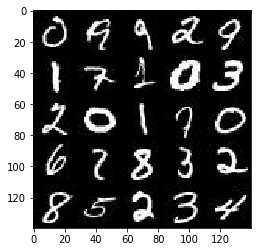

In [77]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

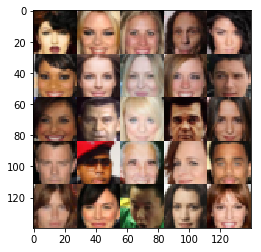

In [78]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [79]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [80]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputImages = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), name = "input_images")
    zInput = tf.placeholder(tf.float32, shape = (None, z_dim), name = "z_input")
    learningRate = tf.placeholder(tf.float32, name = "learning_rate")
    
    return inputImages, zInput, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [81]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.05
    
    with tf.variable_scope("discriminator", reuse = reuse) as disc_scope:
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        # 4096
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [82]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.05
    
    with tf.variable_scope('generator', reuse = (not is_train)):
    
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.shape)
        # 7x7#512

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        # 14x14#256

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        #28x28x64

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)

        return out
    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [83]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    labels = tf.ones_like(d_model_real) * 0.90

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=labels)
        )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [84]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [85]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [86]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_images *= 2.0
                
                # Sample random noize
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate })
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate })
                
                if steps % 10 == 0:
                    # Show loss
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z,  data_shape[3], data_image_mode)
    return
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5127... Generator Loss: 2.0484
Epoch 1/2... Discriminator Loss: 0.4272... Generator Loss: 2.6802
Epoch 1/2... Discriminator Loss: 2.1342... Generator Loss: 0.2136
Epoch 1/2... Discriminator Loss: 0.4163... Generator Loss: 3.7485
Epoch 1/2... Discriminator Loss: 0.4716... Generator Loss: 2.5544
Epoch 1/2... Discriminator Loss: 0.4318... Generator Loss: 2.7489
Epoch 1/2... Discriminator Loss: 0.3813... Generator Loss: 3.9216
Epoch 1/2... Discriminator Loss: 0.6121... Generator Loss: 1.7419
Epoch 1/2... Discriminator Loss: 1.6911... Generator Loss: 0.4486
Epoch 1/2... Discriminator Loss: 1.4555... Generator Loss: 0.7079


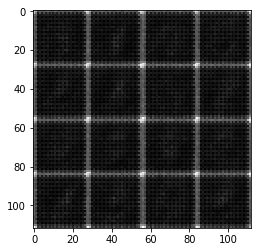

Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 1.1211
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 0.8810
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 0.9830
Epoch 1/2... Discriminator Loss: 1.1999... Generator Loss: 0.8071
Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 1.3049
Epoch 1/2... Discriminator Loss: 1.1556... Generator Loss: 0.8032
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 1.1718
Epoch 1/2... Discriminator Loss: 1.0524... Generator Loss: 1.3880
Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 1.0604


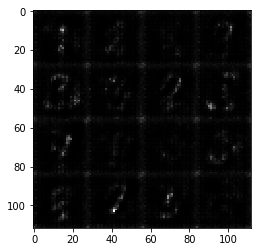

Epoch 1/2... Discriminator Loss: 1.0468... Generator Loss: 1.5897
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 0.9153
Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 1.3324
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 1.8836
Epoch 1/2... Discriminator Loss: 1.0832... Generator Loss: 0.8448
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 0.8942
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 1.2894
Epoch 1/2... Discriminator Loss: 0.9362... Generator Loss: 1.0676
Epoch 1/2... Discriminator Loss: 0.9119... Generator Loss: 1.0295


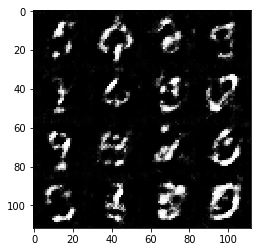

Epoch 1/2... Discriminator Loss: 0.9909... Generator Loss: 0.9166
Epoch 1/2... Discriminator Loss: 0.7940... Generator Loss: 1.3844
Epoch 1/2... Discriminator Loss: 0.8912... Generator Loss: 1.5313
Epoch 1/2... Discriminator Loss: 1.0206... Generator Loss: 0.8707
Epoch 1/2... Discriminator Loss: 0.7584... Generator Loss: 2.1431
Epoch 1/2... Discriminator Loss: 0.8483... Generator Loss: 1.1897
Epoch 1/2... Discriminator Loss: 0.8524... Generator Loss: 1.4042
Epoch 1/2... Discriminator Loss: 0.9358... Generator Loss: 2.5770
Epoch 1/2... Discriminator Loss: 0.8439... Generator Loss: 1.5983
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.8816


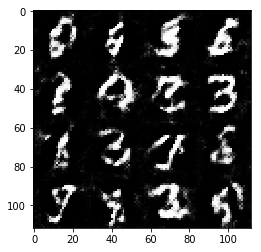

Epoch 1/2... Discriminator Loss: 0.8241... Generator Loss: 1.3012
Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 1.8565
Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 1.6026
Epoch 1/2... Discriminator Loss: 1.0431... Generator Loss: 0.7902
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 1.5430
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 1.5443
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 2.0289
Epoch 1/2... Discriminator Loss: 0.8614... Generator Loss: 1.4360
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.5568


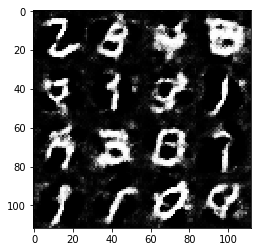

Epoch 1/2... Discriminator Loss: 0.8956... Generator Loss: 1.0971
Epoch 1/2... Discriminator Loss: 0.8236... Generator Loss: 1.6286
Epoch 1/2... Discriminator Loss: 0.9795... Generator Loss: 0.9917
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 0.8464
Epoch 1/2... Discriminator Loss: 1.1899... Generator Loss: 2.1819
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 1.2858
Epoch 1/2... Discriminator Loss: 0.9534... Generator Loss: 1.2017
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 0.9980... Generator Loss: 1.0226
Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 1.0872


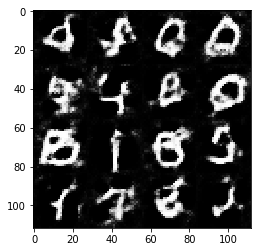

Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 0.8173
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 0.8307
Epoch 1/2... Discriminator Loss: 0.9364... Generator Loss: 1.0809
Epoch 1/2... Discriminator Loss: 1.0541... Generator Loss: 0.9089
Epoch 1/2... Discriminator Loss: 1.0121... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 1.8821
Epoch 1/2... Discriminator Loss: 0.8711... Generator Loss: 1.2824
Epoch 1/2... Discriminator Loss: 1.0575... Generator Loss: 1.0051
Epoch 1/2... Discriminator Loss: 0.9377... Generator Loss: 1.2023
Epoch 1/2... Discriminator Loss: 0.9255... Generator Loss: 1.3718


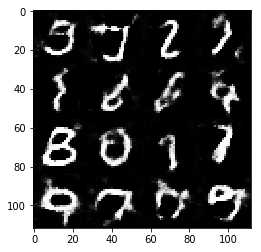

Epoch 1/2... Discriminator Loss: 0.8728... Generator Loss: 1.3079
Epoch 1/2... Discriminator Loss: 1.0222... Generator Loss: 1.4314
Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 1.2750
Epoch 1/2... Discriminator Loss: 0.9910... Generator Loss: 1.2156
Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 1.2491
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 0.6840
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 0.9889
Epoch 1/2... Discriminator Loss: 0.9942... Generator Loss: 1.0578
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 1.8707
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 1.1067


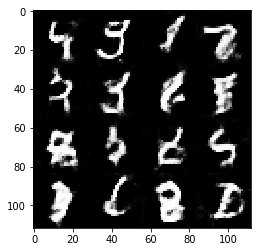

Epoch 1/2... Discriminator Loss: 0.8962... Generator Loss: 1.1495
Epoch 1/2... Discriminator Loss: 0.9003... Generator Loss: 1.4332
Epoch 1/2... Discriminator Loss: 0.9136... Generator Loss: 1.1591
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.6820
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 0.6960
Epoch 1/2... Discriminator Loss: 1.2543... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 0.9765
Epoch 1/2... Discriminator Loss: 0.9774... Generator Loss: 1.0366
Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 0.8963
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 0.6491


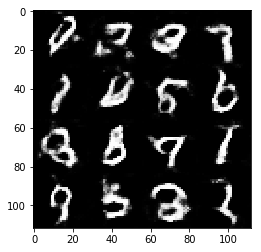

Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 1.0113... Generator Loss: 1.6694
Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 2.1053
Epoch 2/2... Discriminator Loss: 0.8068... Generator Loss: 1.3786
Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 1.0813
Epoch 2/2... Discriminator Loss: 0.9964... Generator Loss: 0.9557
Epoch 2/2... Discriminator Loss: 0.9562... Generator Loss: 1.1190
Epoch 2/2... Discriminator Loss: 1.0491... Generator Loss: 0.9126
Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.3765
Epoch 2/2... Discriminator Loss: 1.0360... Generator Loss: 0.9119


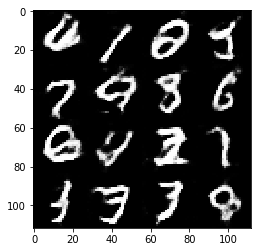

Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: 0.8729... Generator Loss: 1.4976
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.8574
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 0.9275
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 0.5803
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 1.0493
Epoch 2/2... Discriminator Loss: 1.1165... Generator Loss: 0.7394
Epoch 2/2... Discriminator Loss: 1.2714... Generator Loss: 0.5845
Epoch 2/2... Discriminator Loss: 1.1189... Generator Loss: 0.7456
Epoch 2/2... Discriminator Loss: 0.9081... Generator Loss: 1.2700


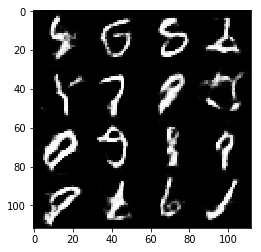

Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 1.0346
Epoch 2/2... Discriminator Loss: 0.9455... Generator Loss: 1.6078
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 1.0417
Epoch 2/2... Discriminator Loss: 0.9505... Generator Loss: 1.0652
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 0.8098
Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 2.7999
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 1.4431
Epoch 2/2... Discriminator Loss: 0.9512... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 0.8486... Generator Loss: 1.2496


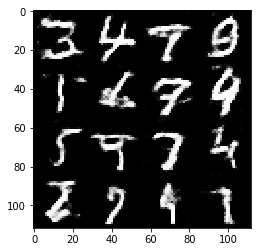

Epoch 2/2... Discriminator Loss: 0.9789... Generator Loss: 1.3000
Epoch 2/2... Discriminator Loss: 0.9034... Generator Loss: 1.0669
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 0.7805
Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 0.9329
Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 1.2370
Epoch 2/2... Discriminator Loss: 1.0021... Generator Loss: 1.4438
Epoch 2/2... Discriminator Loss: 0.9508... Generator Loss: 1.6242
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 1.0105
Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 1.2023
Epoch 2/2... Discriminator Loss: 0.7979... Generator Loss: 1.4772


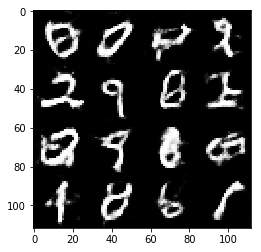

Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 0.8955
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 1.0583
Epoch 2/2... Discriminator Loss: 0.9062... Generator Loss: 1.1953
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 1.3476
Epoch 2/2... Discriminator Loss: 0.9312... Generator Loss: 1.1508
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 1.1307
Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 0.6897
Epoch 2/2... Discriminator Loss: 0.8663... Generator Loss: 1.2368
Epoch 2/2... Discriminator Loss: 1.0161... Generator Loss: 2.2079


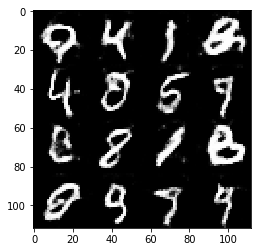

Epoch 2/2... Discriminator Loss: 0.9772... Generator Loss: 1.0038
Epoch 2/2... Discriminator Loss: 1.0045... Generator Loss: 1.7546
Epoch 2/2... Discriminator Loss: 0.9675... Generator Loss: 1.3687
Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 1.1926
Epoch 2/2... Discriminator Loss: 1.0191... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 1.7077
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 1.7909
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 1.5508
Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 1.9103
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.4683


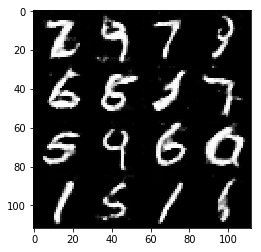

Epoch 2/2... Discriminator Loss: 1.5145... Generator Loss: 0.4846
Epoch 2/2... Discriminator Loss: 1.2685... Generator Loss: 0.6164
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 1.1093
Epoch 2/2... Discriminator Loss: 0.9374... Generator Loss: 1.4406
Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 1.1757
Epoch 2/2... Discriminator Loss: 1.2041... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 0.8476... Generator Loss: 1.6669
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 1.2578
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 1.7217
Epoch 2/2... Discriminator Loss: 0.8691... Generator Loss: 1.2043


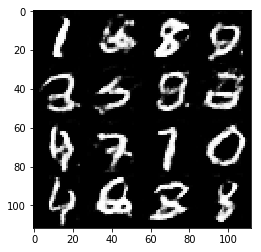

Epoch 2/2... Discriminator Loss: 0.8839... Generator Loss: 1.1974
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.6959
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.4216
Epoch 2/2... Discriminator Loss: 0.9145... Generator Loss: 1.5885
Epoch 2/2... Discriminator Loss: 0.9140... Generator Loss: 0.9660
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.8670
Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 1.6213
Epoch 2/2... Discriminator Loss: 0.8217... Generator Loss: 1.4045
Epoch 2/2... Discriminator Loss: 0.9870... Generator Loss: 0.8655
Epoch 2/2... Discriminator Loss: 0.8914... Generator Loss: 1.0277


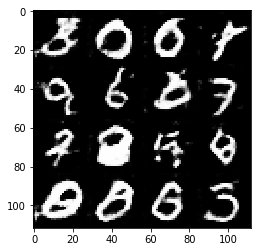

Epoch 2/2... Discriminator Loss: 1.0531... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 1.1126
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 0.7369
Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 1.7334
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 1.4812
Epoch 2/2... Discriminator Loss: 0.9571... Generator Loss: 1.6454
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.1002
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 0.9728
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 0.9815


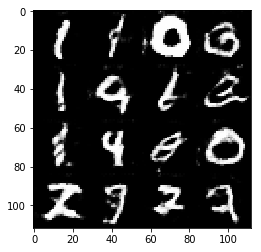

Epoch 2/2... Discriminator Loss: 0.8321... Generator Loss: 1.7067
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 0.8679
Epoch 2/2... Discriminator Loss: 0.8752... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 1.2433
Epoch 2/2... Discriminator Loss: 1.3895... Generator Loss: 2.3554
Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 1.2881
Epoch 2/2... Discriminator Loss: 0.9112... Generator Loss: 1.0666


In [87]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 1.4657
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 2.1906
Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 1.5733
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.5177
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.2594
Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 1.8877


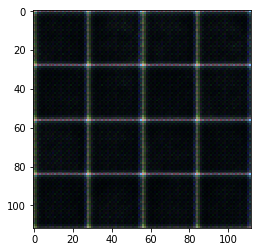

Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 2.9965
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 2.7639
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 3.3384
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 2.8824
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 2.5242


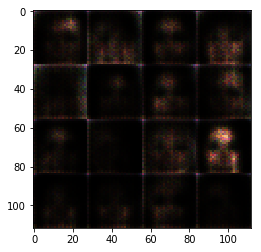

Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.8148
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 1.3996
Epoch 1/1... Discriminator Loss: 0.7094... Generator Loss: 1.6863
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 2.5684
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 2.3846
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 1.8570
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 1.6010


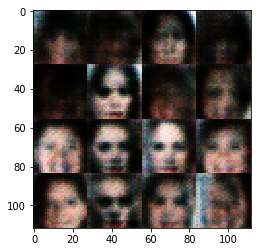

Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.3517
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.0659
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 3.0402
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 1.9890
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.8710
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 3.7949
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 3.1682
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 1.2358


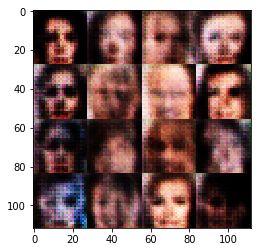

Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 3.2542
Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 3.8700
Epoch 1/1... Discriminator Loss: 2.1221... Generator Loss: 0.2349
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.7083
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.5179
Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 4.2409
Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 1.4126


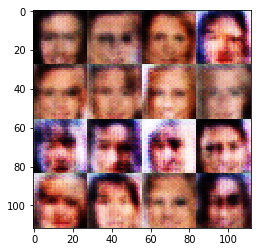

Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.6869
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 1.6387
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 3.5155
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 1.5566
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 1.9405
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.0570


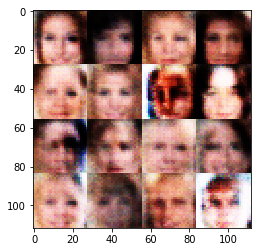

Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 3.7063
Epoch 1/1... Discriminator Loss: 0.7036... Generator Loss: 1.5656
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 1.4457
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 1.7927
Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.3623
Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 1.5547
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.4081
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 2.9174
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.9232
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.9960


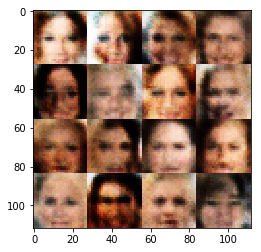

Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.2676
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 2.3356
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.4603
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 3.7692
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.3201
Epoch 1/1... Discriminator Loss: 2.3996... Generator Loss: 0.1781


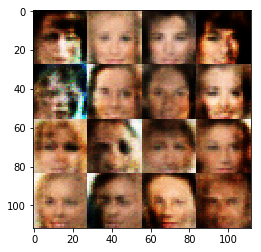

Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 4.2538
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.3480
Epoch 1/1... Discriminator Loss: 0.5489... Generator Loss: 2.2395
Epoch 1/1... Discriminator Loss: 0.5675... Generator Loss: 1.8523
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.7530
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 5.1677
Epoch 1/1... Discriminator Loss: 0.6794... Generator Loss: 1.5993
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 2.5703
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 2.7024


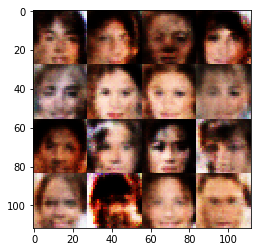

Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 0.5752... Generator Loss: 2.2839
Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 2.6353
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 2.1883
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 4.7994
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 2.9375
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 2.0097
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 3.1905


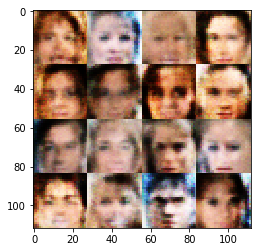

Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 3.2684
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 3.6171
Epoch 1/1... Discriminator Loss: 0.5723... Generator Loss: 2.8092
Epoch 1/1... Discriminator Loss: 0.5616... Generator Loss: 2.0856
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 0.6471... Generator Loss: 1.7484
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 2.5555


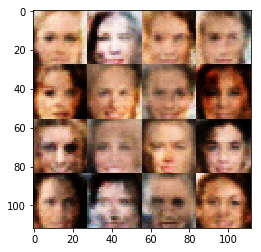

Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 5.2883
Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 5.1106
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 1.4094
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 2.2232
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 3.9193
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 2.7195
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 2.2687
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 2.6112
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 2.1917


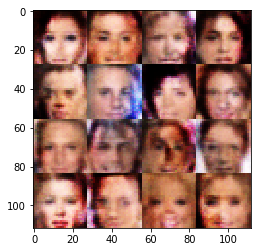

Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 2.4784
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 2.0357
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.7726
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 1.8244
Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 1.4743
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 2.3740


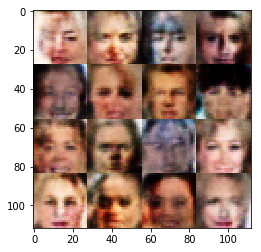

Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 2.1530
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.2940
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 0.6332... Generator Loss: 1.9503
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.5050
Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 1.3691
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 2.4954
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 2.0583


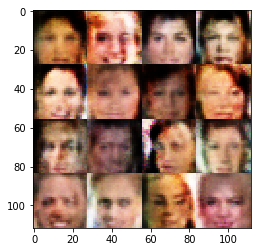

Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.8257


KeyboardInterrupt: 

In [88]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.